In [1]:
#default_exp fluorescence_intensity

# Fluorescence intensity

> API details.

In [2]:
# hide
from nbdev.showdoc import *

In [3]:
# %load common.py
# export

import pandas
import os
import numpy
import seaborn
import logging
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib
from importlib import reload
from ehv import core
from joblib import load, dump
from pathlib import Path
import uuid
import re
import scipy

from ehv import load as e_load, core

plt.rcParams['figure.facecolor'] = 'white'

numpy.random.seed(42)

In [6]:
# export
import flowutils
import pyarrow.parquet as pq
reload(e_load)

<module 'ehv.load' from '/vsc-mounts/gent-user/420/vsc42015/projects/weizmann-ehv-analysis/ehv/load.py'>

In [13]:
samples = None
df = e_load.load_raw_ideas_dir(
    Path("/data/weizmann/EhV/high_time_res"), 
    Path("/data/weizmann/EhV/weizmann-ehv-metadata/representations/ideas_features/"), 
    "ALL", 
    Path("/data/weizmann/EhV/weizmann-ehv-metadata/cell_populations/manual_gating/"),
    samples, "Low/*.cif")
df = e_load.remove_unwanted_features(df)
df = e_load.tag_columns(df)
df = e_load.clean_column_names(df)

df = df[df["meta_label_coi"]]

reg = r"^meta_label_(.+)$"
label_vec = numpy.full((df.shape[0]), fill_value="unknown", dtype=object)
for col in df.filter(regex="(?i)meta_label_.*psba.*"):
    label_vec[df[col].values] = re.match(reg, col).groups(1)
    
df["meta_label"] = label_vec

df = df.reset_index(drop=True)

In [9]:
index = numpy.load("/vsc-mounts/gent-user/420/vsc42015/vsc_data_vo/datasets/weizmann/EhV/v2/meta/single_focused_index.npy", allow_pickle=True)
df = pq.read_table("/vsc-mounts/gent-user/420/vsc42015/vsc_data_vo/datasets/weizmann/EhV/v2/results/202110252052/features.parquet").to_pandas().loc[index]

# Inspect intensity distributions

In [39]:
# export
def apply_logicle(df, columns=["feat_intensity_mc_ch04", "feat_intensity_mc_ch11", "feat_intensity_mc_ch7"]):
    df = df.copy()
    for (t_idx, r_idx), group_df in df.groupby(["meta_timepoint", "meta_replicate"]):
        for feat in columns:
            y = group_df[[feat]].values
            df.loc[(df["meta_timepoint"] == t_idx) & (df["meta_replicate"] == r_idx), feat+"_logicle"] = \
                flowutils.transforms.logicle(y, numpy.arange(y.shape[1]))
    return df

In [17]:
df = apply_logicle(df)

In [17]:
df["meta_index"] = df.index.map(lambda a: a.split("_")[1]).values

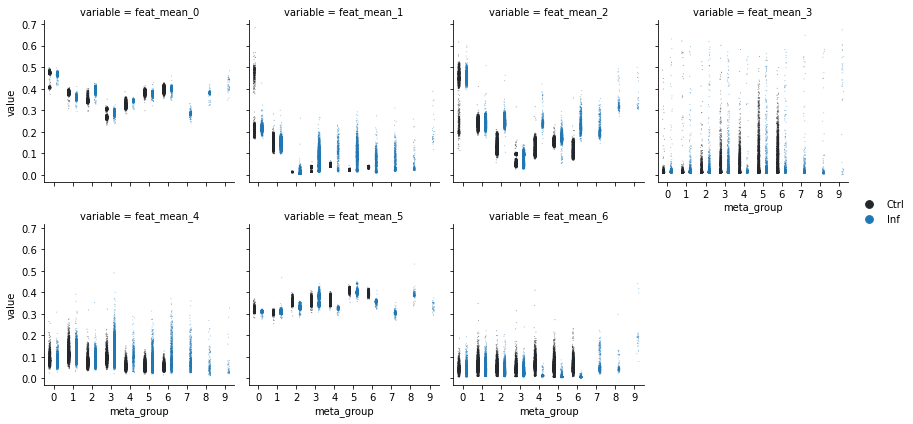

In [41]:
melted_df = pandas.melt(df, id_vars=["meta_index", "meta_type", "meta_group", "meta_replicate"], value_vars=df.filter(regex="feat_mean_").columns)
grid = seaborn.FacetGrid(data=melted_df, col="variable", col_wrap=4)
grid.map_dataframe(seaborn.stripplot, x="meta_group", y="value", hue="meta_type", dodge=True, size=1, alpha=0.5)
grid.add_legend()

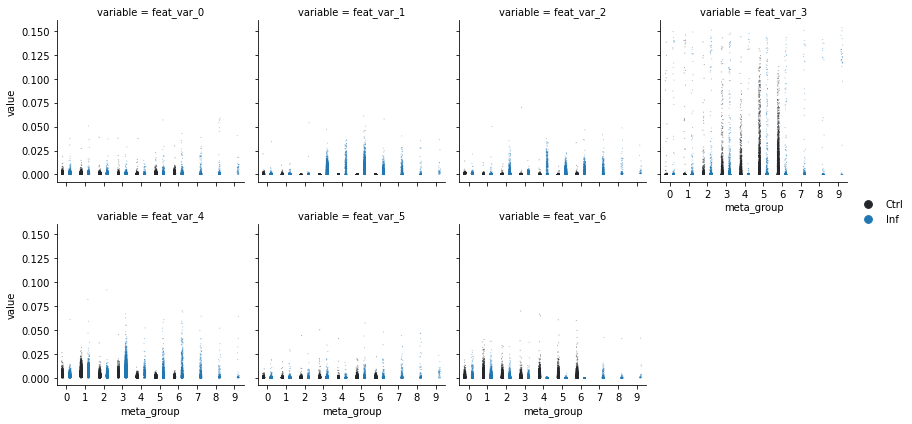

In [48]:
melted_df = pandas.melt(df, id_vars=["meta_index", "meta_type", "meta_group", "meta_replicate"], value_vars=df.filter(regex="feat_var_").columns)
grid = seaborn.FacetGrid(data=melted_df, col="variable", col_wrap=4)
grid.map_dataframe(seaborn.stripplot, x="meta_group", y="value", hue="meta_type", dodge=True, size=1, alpha=0.5)
grid.add_legend()

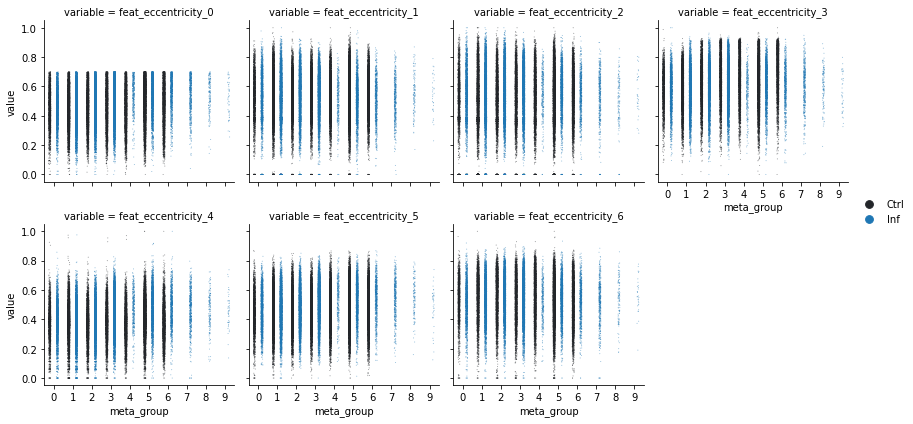

In [49]:
melted_df = pandas.melt(df, id_vars=["meta_index", "meta_type", "meta_group", "meta_replicate"], value_vars=df.filter(regex="feat_eccentricity_").columns)
grid = seaborn.FacetGrid(data=melted_df, col="variable", col_wrap=4)
grid.map_dataframe(seaborn.stripplot, x="meta_group", y="value", hue="meta_type", dodge=True, size=1, alpha=0.5)
grid.add_legend()

# Export for PeacoQC

In [22]:
from ehv import export
reload(export)

<module 'ehv.export' from 'd:\\dev\\active\\ehv-analysis\\ehv\\export.py'>

In [23]:
for (t_idx, r_idx), grouped_df in df_201.groupby(["timepoint", "replicate"]):
    tmp_df = grouped_df[["Intensity_MC_TMR", "Intensity_MC_Cy5", "Intensity_MC_DAPI", "Intensity_MC_TMR_logicle", "Intensity_MC_Cy5_logicle", "Intensity_MC_DAPI_logicle", "label"]].copy()
    tmp_df["Time"] = grouped_df.index
    export.to_fcs(tmp_df, os.path.join("D:/Experiment_data/weizmann/EhV/201/", t_idx, r_idx, f"fluor_{t_idx}_{r_idx}.fcs"), encode=["label"])

In [198]:
for (t_idx, r_idx), grouped_df in df_control.groupby(["timepoint", "replicate"]):
    tmp_df = grouped_df[["Intensity_MC_TMR", "Intensity_MC_Cy5", "Intensity_MC_DAPI", "Intensity_MC_TMR_logicle", "Intensity_MC_Cy5_logicle", "Intensity_MC_DAPI_logicle"]].copy()
    tmp_df["Time"] = grouped_df.index
    export.to_fcs(tmp_df, os.path.join("D:/Experiment_data/weizmann/EhV/control/", t_idx, r_idx, f"fluor_{t_idx}_{r_idx}.fcs"), encode=[])

See scripts/PeacoQC.Rmd for analysis in R. QC showed no problematic files.

In [24]:
export.to_fcs(
    df_201[["Intensity_MC_TMR", "Intensity_MC_Cy5", "Intensity_MC_DAPI", "Intensity_MC_TMR_logicle", "Intensity_MC_Cy5_logicle", "Intensity_MC_DAPI_logicle"]],
    "D:/Experiment_data/weizmann/EhV/201/aggregates/fluor_T0234567_R123.fcs",
    encode=[]
)